In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
from collections import defaultdict
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option("display.precision", 2)

## Configurations

In [12]:
rd = 5
start_week = Week(2021,18)
end_week = Week(2021,43)
models = ["Ensemble","Ensemble_LOP","IHME-IHME_COVID_model_deaths_unscaled","JHUAPL-Bucky","JHU_IDD-CovidSP","Karlen-pypm",
           "MOBS_NEU-GLEAM_COVID","UNCC-hierbin","USC-SIkJalpha","UVA-adaptive"]
max_date = datetime.datetime(2021, 6, 23)

In [2]:
rd = 12
start_week = Week(2022,2)
end_week = Week(2022,13)
max_date = datetime.datetime(2022, 3, 15)
models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","NCSU-COVSIM","NotreDame-FRED","UNCC-hierbin","USC-SIkJalpha",
          "UTA-ImmunoSEIRS","UVA-EpiHiper","UVA-adaptive"]

In [2]:
rd = 14
start_week = Week(2022,23)
end_week = Week(2023,22)
max_date = None
models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","MOBS_NEU-GLEAM_COVID_OT","NCSU-COVSIM",
          "UNCC-hierbin","USC-SIkJalpha","USC-SIkJalpha-update","UTA-ImmunoSEIRS","UVA-adaptive"]

In [12]:
#target = 'death'
target = 'hosp'
incidence = True
target_location = 'US'

locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
location_mapping = dict()
for loc in locations['location']:
    location_mapping[loc] = locations[locations['location'] == loc]['abbreviation'].unique()[0]

## Load and format surveillance data

In [13]:
if target == 'hosp':
    target_obs = 'hospitalization'
else:
    target_obs = target
observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

#filter start - end week
observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                            (observations['date'] <= pd.to_datetime(end_week.enddate()))]


    
#filter location
observations = observations[observations['location'] == target_location]

#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

if max_date:
    observations = observations[observations['date'] <= max_date].copy()

#transform to Observation object
observations = Observations(observations)

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_41089/177555968.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()


## Load predictions, filter and build ensemble

In [14]:
target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,len(observations)+1)]

In [15]:
median_ensembles = dict()
extreme_ensembles = dict()
for model in models:    
    try:
        predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')
        predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
        predictions = predictions.merge(locations, how='inner', on='location')

        pred = predictions[predictions['location'] == target_location].copy()
        
        #filter target
        pred = pred[(pred['target'].isin(target_prediction_list))]
            
        #filter max date
        if max_date:
            pred = pred[pred['target_end_date'] <= max_date]

        if len(pred) == 0:
            raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

        scenarios = list(pred['scenario_id'].drop_duplicates())
        predictions_list = [Predictions(pred[pred['scenario_id'] == scenario], t_col='target_end_date') for scenario in scenarios]
        med_ensemble_predictions = median_ensemble(predictions_list)
        ex_ensemble_predictions = extreme_ensemble(predictions_list)
        median_ensembles[model] = med_ensemble_predictions
        extreme_ensembles[model] = ex_ensemble_predictions
    except Exception as e:
        print(e)

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location US
There are no predictions for model NotreDame-FRED at location US
[Errno 2] No such file or directory: './dat/UNCC-hierbin_rd12.pq'


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location US


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

## Plot

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
#intervals to show
intervals = [(0.01,0.99),(0.05,0.95),(0.25,0.75)]
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)
    
fontsize=14
plt.style.use('seaborn-paper')
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{lmodern}\usepackage{sfmath}')
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rc('axes', labelsize=fontsize)
color = '#17B1BF'

In [17]:
nb_rows = len(median_ensembles) // 3 + int(len(median_ensembles)%3 > 0)

### Median and extreme aggregate

In [18]:
aggregates = [median_ensembles,extreme_ensembles]
titles = ['Median aggregate', 'Extreme aggregate']

In [19]:
target_loc_name = location_mapping[target_location]

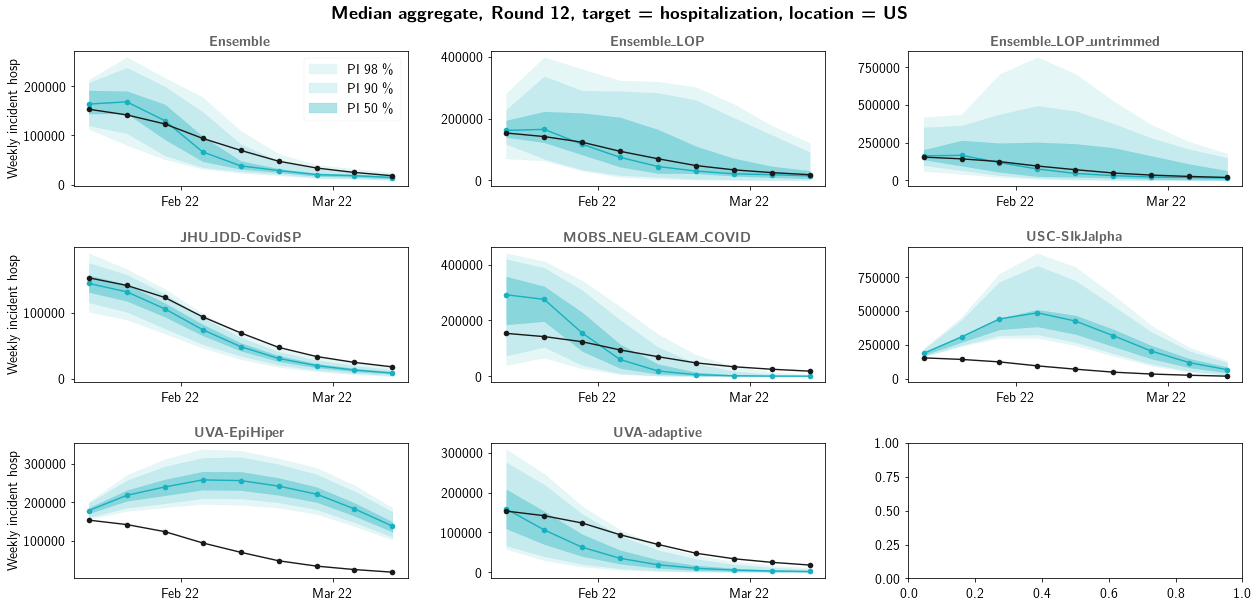

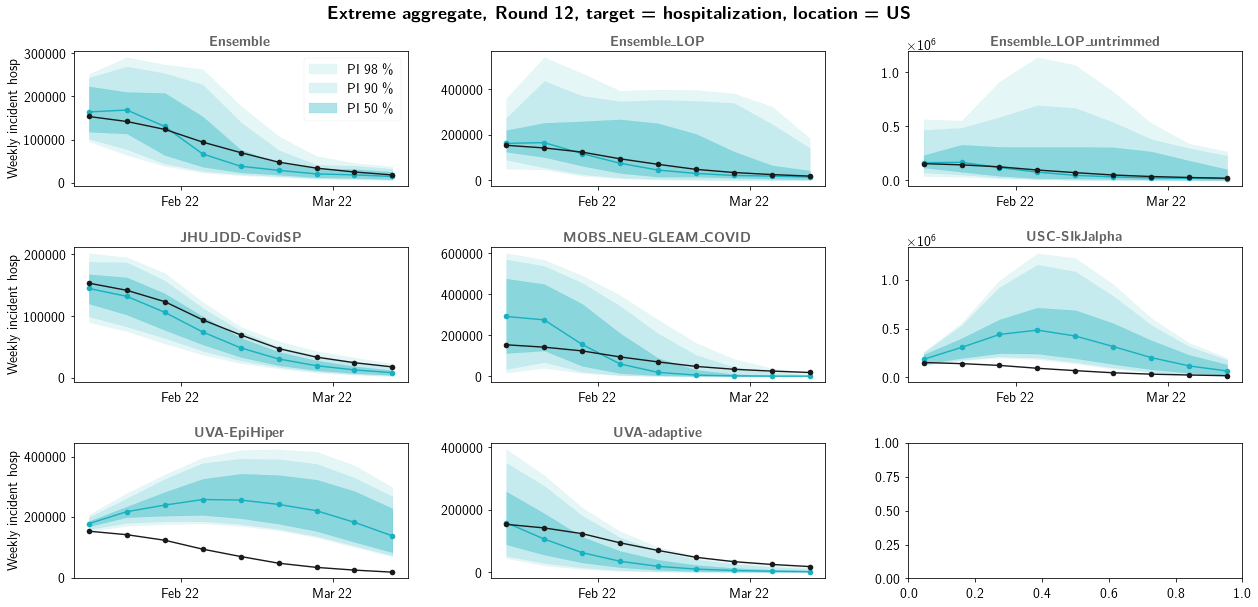

In [20]:
width = 7.057*2.5
height = width/2.*nb_rows/3

for title,aggregate in zip(titles,aggregates):
    fig, axes = plt.subplots(nb_rows,3, figsize=(width, height), sharey=False)
    plt.subplots_adjust(left=0.07, bottom=0.08, right=0.99, top=0.91, wspace=0.25,
                        hspace=0.45)
    #title whole figure
    fig.suptitle(r"\textbf"+"{"+f"{title}, Round {rd}, target = {target_obs}, location = {target_loc_name}"+"}", fontsize=fontsize+4)
    for ind,(label,predictions) in enumerate(aggregate.items()):
        i = ind // 3
        j = ind % 3

        #title
        # axes[i][j].text(0.5,1.1,r"\textbf"+"{"+f"{label}"+"}",
        #                 fontsize=fontsize, ha='center',
        #                 transform=axes[i][j].transAxes)
        axes[i][j].set_title(r"\textbf"+"{"+f"{label}"+"}",
                             fontsize=fontsize, color='#636363')

        t = np.unique(predictions.get_t())

        #intervals
        for interval in intervals:
            q_low,q_upp = interval
            interval_range = q_upp - q_low
            alpha = map_alpha(interval_range)
            pred_low = predictions.get_quantile(q_low)
            pred_upp = predictions.get_quantile(q_upp)
            axes[i][j].fill_between(t,pred_upp,pred_low, color=color, alpha=alpha,
                                   label=fr"PI {int(round(interval_range*100))} \%")
        if i == 0 and j == 0:
            axes[i][j].legend(frameon=True, fontsize=fontsize)

        #point estimate
        pred_point = predictions.get_point()
        if len(pred_point) > 0:
            axes[i][j].plot(t,pred_point,'-o',color=color)

        #plot surveillance
        axes[i][j].plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a')

        #set x axis
        set_date_axis_fmt(axes[i][j])


        #set y axis 
        axes[i][0].set_ylabel(f"Weekly {'incident' if incidence else 'cumulative'} {target}")
        
    path = f"./figs/rd{rd}/{'inc' if incidence else 'cum'}_{target}/{target_loc_name}/"
    Path(path).mkdir(parents=True, exist_ok=True)

    plt.savefig(path+f"{title}.pdf")